# EDA & Train/Test Split
This notebook performs initial EDA and creates a fixed 70/30 train/test split.

**Deliverables produced here:**
- Summary stats, missingness checks, distributions, correlation matrix
- Transformation based on skewness
- Frozen 70/30 split CSVs saved to `data/`


In [7]:
# pip install ucimlrepo

In [122]:
from ucimlrepo import fetch_ucirepo 
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [124]:
# fetch dataset 
concrete_compressive_strength = fetch_ucirepo(id=165) 

X = concrete_compressive_strength.data.features 
y = concrete_compressive_strength.data.targets

# create full df for EDA
df = pd.concat([y, X], axis=1)
  
# metadata 
print(concrete_compressive_strength.metadata) 
  
# variable information 
print(concrete_compressive_strength.variables) 

{'uci_id': 165, 'name': 'Concrete Compressive Strength', 'repository_url': 'https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength', 'data_url': 'https://archive.ics.uci.edu/static/public/165/data.csv', 'abstract': 'Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. ', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1030, 'num_features': 8, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Concrete compressive strength'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5PK67', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 383, 'type': 'NATIVE', 'title': 'Modeling of strength of high-performance concrete using artificial neural networks', 'authors': 'I. Yeh', 'venue': 'C

In [125]:
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
df.head()

Shape: (1030, 9)

Columns: ['Concrete compressive strength', 'Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age']


,Concrete compressive strength,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,79.99,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,61.89,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,40.27,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,41.05,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,44.30,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [126]:
# standardize column names
df.columns = [c.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

print("\nStandardized columns:", list(df.columns))


Standardized columns: ['concrete_compressive_strength', 'cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']


In [127]:
display(df.describe(include='all'))
print("\nMissing values per column:")
print(df.isna().sum())

,concrete_compressive_strength,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,35.817961,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136
std,16.705742,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912
min,2.330000,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,23.710000,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000
50%,34.445000,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000
75%,46.135000,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000
max,82.600000,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000



Missing values per column:
concrete_compressive_strength    0
cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
dtype: int64


In [128]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
skew = df[numeric_cols].skew(numeric_only=True)
print("Skewness by numeric column:")
print(skew.sort_values(ascending=False))

Skewness by numeric column:
age                              3.269177
superplasticizer                 0.907203
blast_furnace_slag               0.800717
fly_ash                          0.537354
cement                           0.509481
concrete_compressive_strength    0.416977
water                            0.074628
coarse_aggregate                -0.040220
fine_aggregate                  -0.253010
dtype: float64


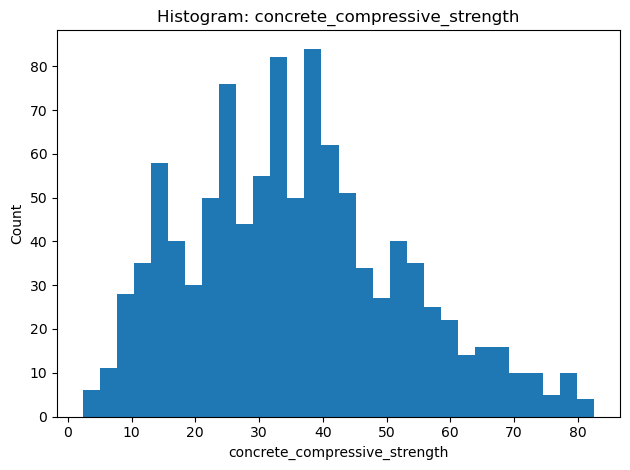

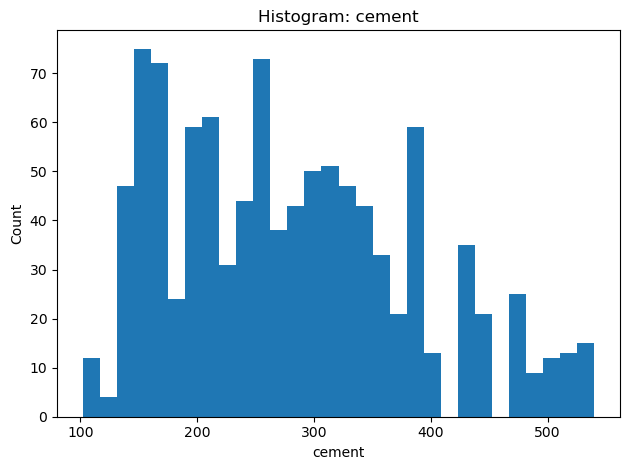

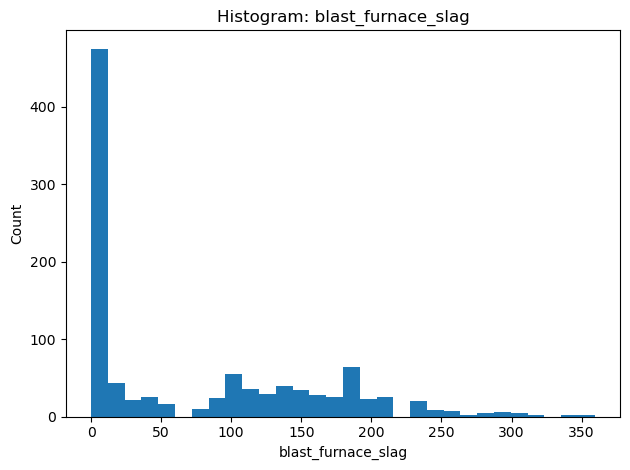

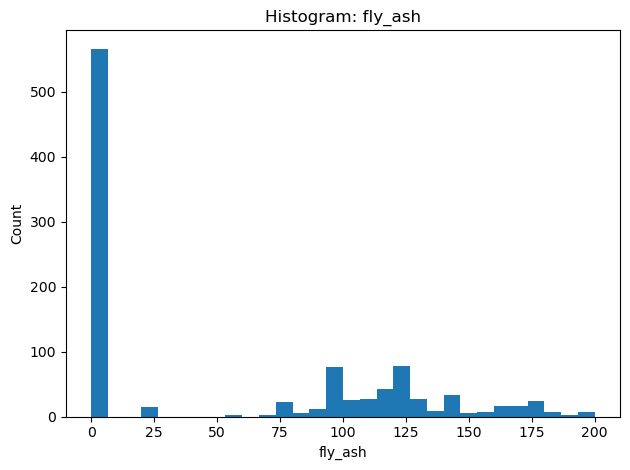

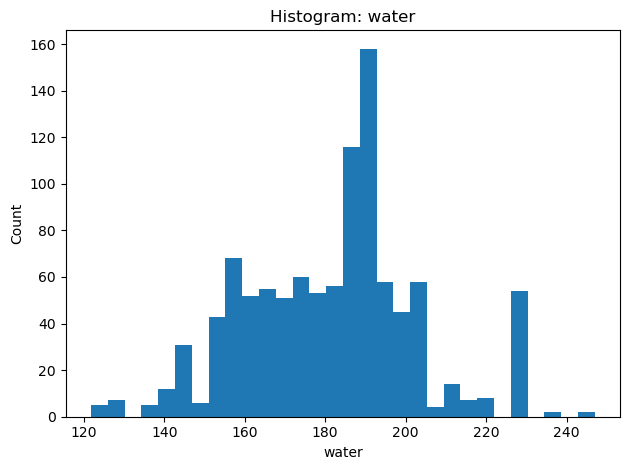

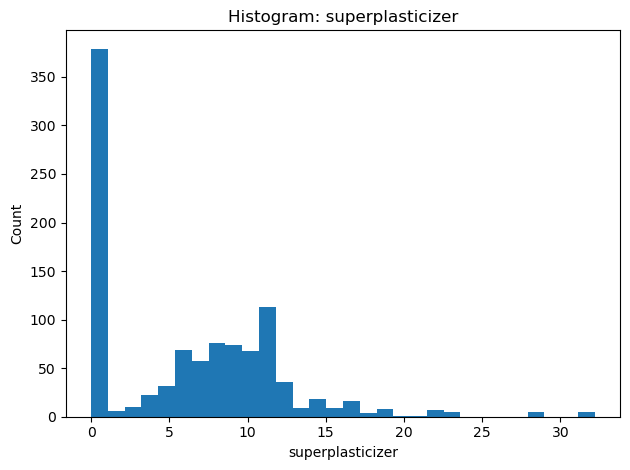

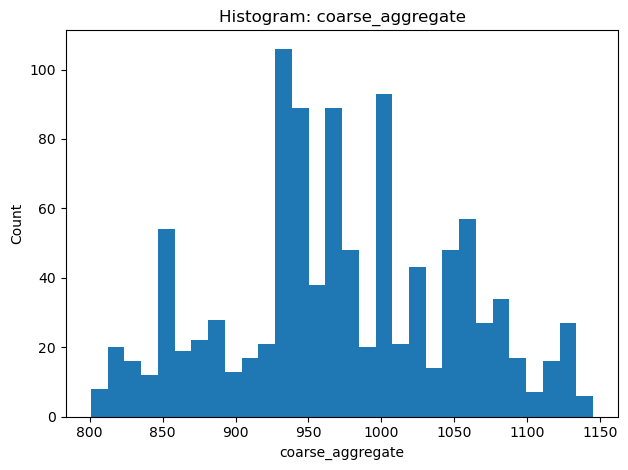

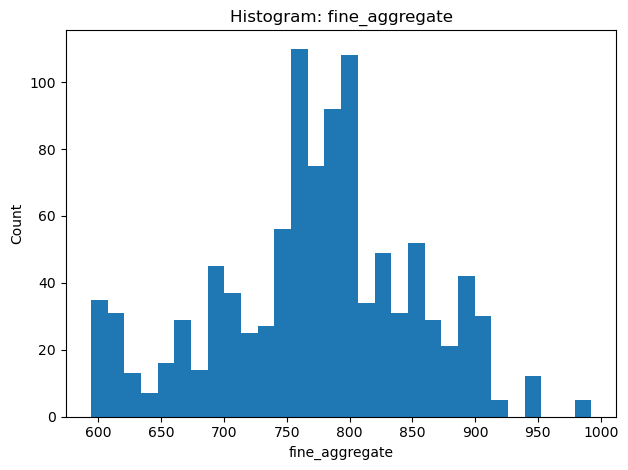

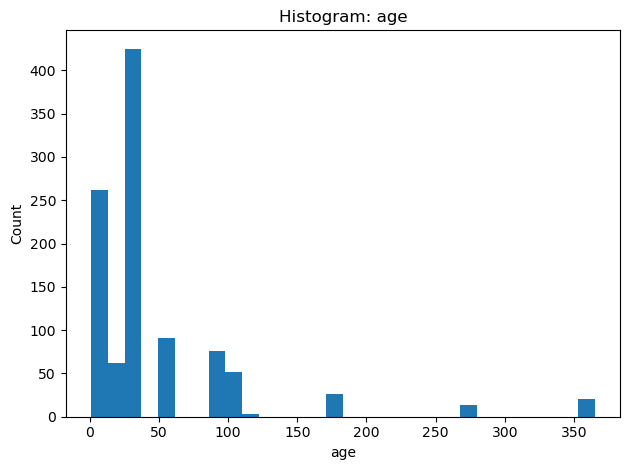

In [134]:
# histograms
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

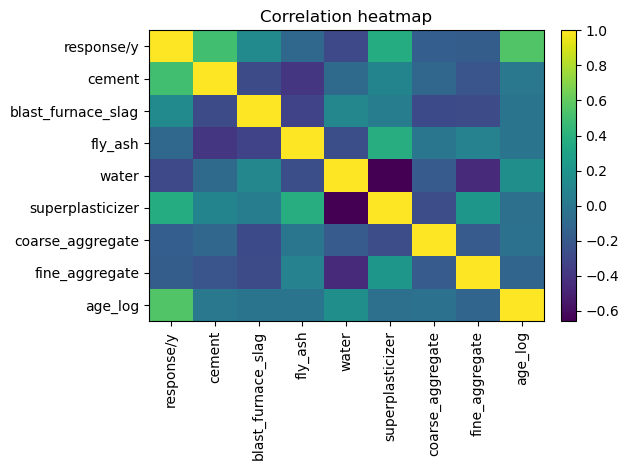

In [156]:
# correlation matrix heatmap
df1 = df.copy(deep=True)
df1 = df1.rename(columns={'concrete_compressive_strength': 'response/y'})
numeric_cols1 = df1.select_dtypes(include=[np.number]).columns.tolist()
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'reports', 'figures')
corr = df1[numeric_cols1].corr()
plt.figure()
im = plt.imshow(corr.values, interpolation='nearest', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols1)), numeric_cols1, rotation=90)
plt.yticks(range(len(numeric_cols1)), numeric_cols1)
plt.title("Correlation heatmap")
plt.savefig(os.path.join(fig_dir, 'corr_heatmap.png'), dpi=320)
plt.tight_layout()
plt.show()

In [152]:
# log transform age due to skewness
df['age_log'] = np.log1p(df['age'])
df = df.drop(['age'], axis=1)

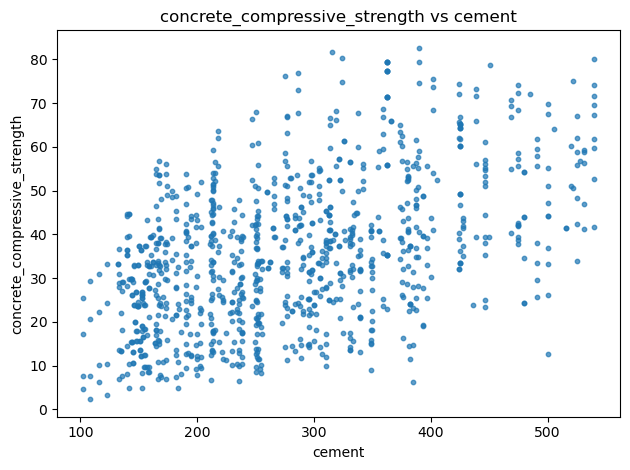

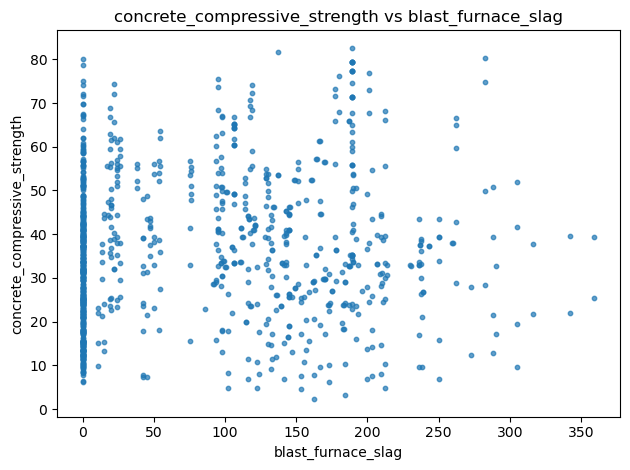

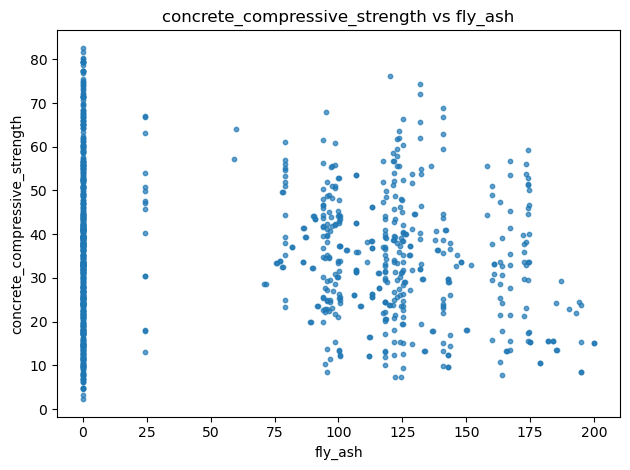

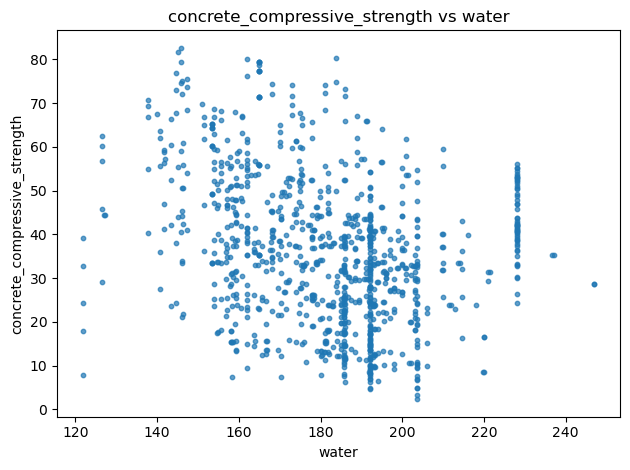

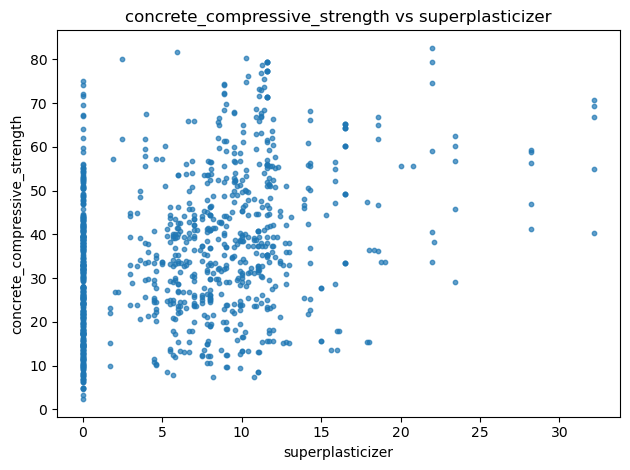

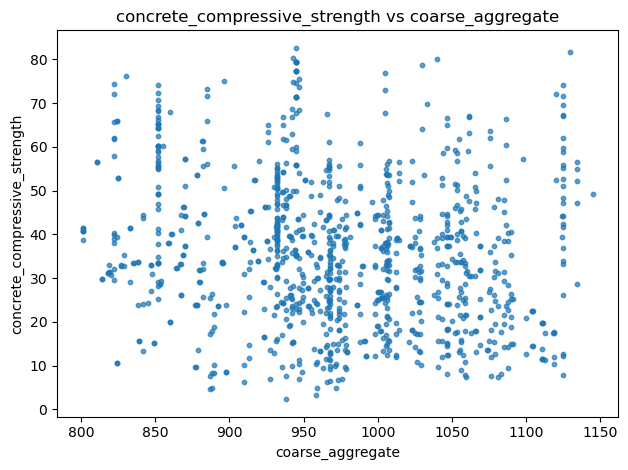

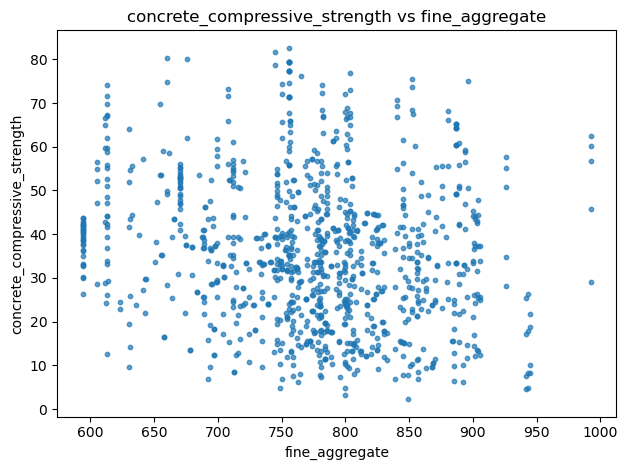

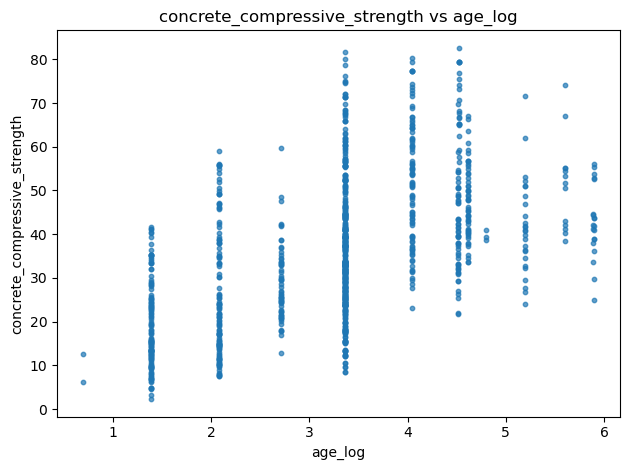

In [154]:
# scatter plots: response vs predictor
y_col = 'concrete_compressive_strength'
predictors = [c for c in df.columns if c != y_col]
for col in predictors:
    plt.figure()
    plt.scatter(df[col], df[y_col], s=10, alpha=0.7)
    plt.xlabel(col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {col}")
    plt.tight_layout()
    plt.show()

In [91]:
# Create frozen train/test split (70/30 with seed=598) and save CSVs
X = df.drop(columns=[y_col])
y = df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=598)
train_df = X_train.copy()
train_df[y_col] = y_train
test_df = X_test.copy()
test_df[y_col] = y_test

In [99]:
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_path = os.path.join(DATA_DIR, 'concrete_train.csv')
test_path  = os.path.join(DATA_DIR, 'concrete_test.csv')
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
print(f"Saved train to: {train_path}")
print(f"Saved test to : {test_path}")

Saved train to: /Users/treyschulman/cs598psl/project2/concrete_project/data/concrete_train.csv
Saved test to : /Users/treyschulman/cs598psl/project2/concrete_project/data/concrete_test.csv
